In [2]:
import ot
import time
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.colors import to_rgba

from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.mixture import GaussianMixture
from scipy.stats import ecdf
from scipy.integrate import simpson
from torchvision.utils import make_grid

from IPython.display import HTML
from matplotlib.animation import FuncAnimation

C:\Users\SL276123\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ot\backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


## Creating Dataset

In [3]:
# Fix seeds
random.seed(15)
np.random.seed(15)
torch.manual_seed(15)


c1 = plt.get_cmap('coolwarm')(0.0)
c2 = plt.get_cmap('coolwarm')(1.0)

plt_cmap = sns.color_palette("coolwarm", as_cmap=True)

In [4]:
def make_dataset(mean, cov, v=None, separation=1, n=200):
    x1 = np.random.multivariate_normal(mean, cov, size=n)
    if v is None:
        v = np.random.randn(2,)
        v = separation * (v / np.linalg.norm(v)).reshape(1, -1)
    elif np.linalg.norm(v) != separation:
        v = separation * (v / np.linalg.norm(v)).reshape(1, -1)
    else:
        v = v.reshape(1, -1)
    x2 = x1 + v
    X = np.concatenate([x1, x2], axis=0)
    y = np.array([0] * len(x1) + [1] * len(x2))

    return X, y

In [5]:
n_dim = 2
n_classes = 2
n_datasets = 4
device = 'cpu'

In [6]:
# Creating datasets
mu = np.array([0, 0])

true_features = []
true_labels = []

separation = 6
angles = [0, 15, 30, 45]
Xs, Ys = [], []
for i in range(n_datasets - 1):
    A = np.random.randn(2, 2)
    cov = .25 * np.dot(A.T, A) + np.eye(2)
    v = np.array([np.cos((np.pi / 180) * angles[i]), np.sin((np.pi / 180) * angles[i])])
    X, y = make_dataset(mu, cov, v=v, separation=separation, n=400)
    true_features.append(X)
    true_labels.append(y)
    
    Xs.append(torch.from_numpy(X).float())
    Ys.append(torch.nn.functional.one_hot(torch.from_numpy(y).long(), num_classes=2).float())

In [7]:
A = np.random.randn(2, 2)
cov = .1 * np.dot(A.T, A) + np.eye(2)
v = np.array([np.cos((np.pi / 180) * angles[-1]), np.sin((np.pi / 180) * angles[-1])])
X, y = make_dataset(mu, cov, v=v, separation=separation, n=400)
Xt_tr = torch.from_numpy(X).float()
Yt_tr = torch.nn.functional.one_hot(torch.from_numpy(y).long(), num_classes=2).float()
true_features.append(X)
true_labels.append(y)

In [8]:
x_minima, x_maxima = [], []
y_minima, y_maxima = [], []

for features in true_features:
    x_minima.append(features[:, 0].min())
    x_maxima.append(features[:, 0].max())
    
    y_minima.append(features[:, 1].min())
    y_maxima.append(features[:, 1].max())
    
xmin, xmax = np.amin(x_minima), np.amax(x_maxima)
ymin, ymax = np.amin(y_minima), np.amax(y_maxima)

print(xmin, xmax, ymin, ymax)

-3.6102320522627234 9.212014518143265 -4.0813975809058896 7.384115192902346


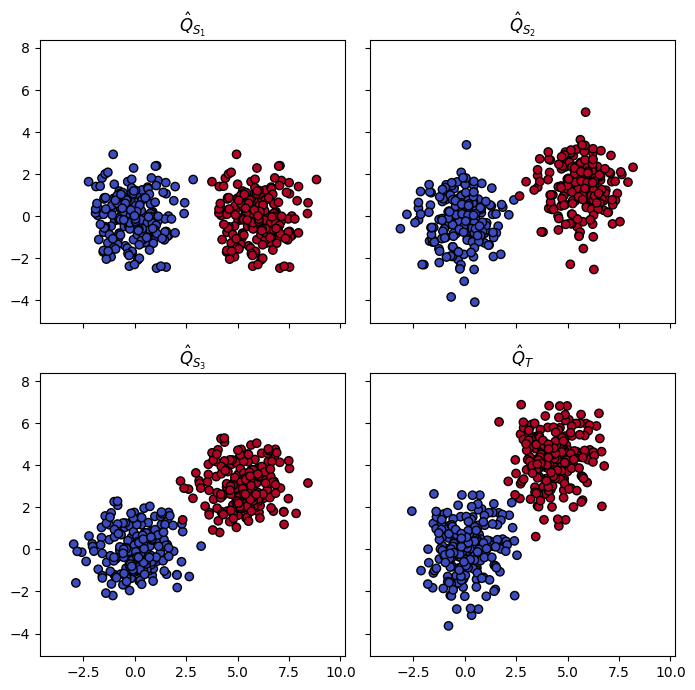

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(7, 7), sharex=True, sharey=True)

for i, (Xi, Yi, ax) in enumerate(zip(true_features[:-1], true_labels[:-1], axes.flatten()[:-1])):
    ax.scatter(x=Xi[::2, 0], y=Xi[::2, 1], c=Yi[::2], cmap='coolwarm', edgecolor='k')
    ax.set_title(r"$\hat{Q}_{S_{" + str(i + 1) + r"}}$")
        
    ax.set_xlim([xmin - 1, xmax + 1])
    ax.set_ylim([ymin - 1, ymax + 1])

ax = axes.flatten()[-1]
Xi = true_features[-1]
Yi = true_labels[-1]

ax.scatter(x=Xi[::2, 0], y=Xi[::2, 1], c=Yi[::2], cmap='coolwarm', edgecolor='k')
ax.set_title(r"$\hat{Q}_{T}$")
plt.tight_layout()

In [10]:
datasets = [(Xsk, Ysk) for Xsk, Ysk in zip(Xs, Ys)] + [(Xt_tr, None)]

## Python implementation of 'ONLINE LEARNING OF GAUSSIAN MIXTURE MODELS: A TWO-LEVEL APPROACH' by Arnaud Declercq, Justus H. Piater

## The precise mixture model

In [11]:
edfx = ecdf(Xt_tr[:,0])
edfy = ecdf(Xt_tr[:,1])

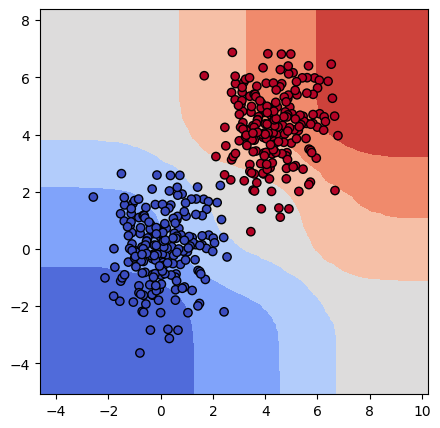

In [18]:
x_range = np.linspace(xmin - 1, xmax + 1, 100)
y_range = np.linspace(ymin - 1, ymax + 1, 100)

x_mesh, y_mesh = np.meshgrid(x_range, y_range)

probax = edfx.cdf.evaluate(x_range)
probay = edfy.cdf.evaluate(y_range)
z = np.zeros((len(probax), len(probay)))
for i in range(len(probax)):
    for j in range(len(probay)):
        z[i, j] = (probax[i] + probay[j])/2

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.contourf(x_mesh, y_mesh, z, cmap=plt.cm.coolwarm, zorder=1)
ax.scatter(x=Xi[::2, 0], y=Xi[::2, 1], c=Yi[::2], cmap='coolwarm', edgecolor='k', zorder=1)

In [ ]:
def fidelity(X: np.ndarray, ecdf: list, rcdf: list, T_D: float):
    distance = 0
    for i in range(len(ecdf)):
        distance += np.linalg.nom(ecdf[i].cdf.evaluate(X[:, i]) - rcdf[i].cdf.evaluate(X[:, i]))
    distance /= len(ecdf)
    fidelity = np.exp(-distance**2/T_D**2)
    return fidelity
    